In [2]:
from matplotlib import font_manager as fm
font_cn = fm.FontProperties(fname='fonts/SourceHanSansSC-Normal.otf')
font_cn.set_weight = 'normal'
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter
scores = defaultdict(dict)

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# constants:
HDF_FPATH = 'Stanford_politeness_corpus/fromJson.hdf'
params = {'kernel':('linear',), 'C':[0.01, 0.05, 0.1, 0.25, 0.5], 'gamma': [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]} # Define search region
import os, re

In [3]:
# Control global random state (https://github.com/scikit-learn/scikit-learn/issues/2046#issuecomment-19173565):
import numpy as np
np.random.seed(42)
import random
random.seed(42)

# On the Stanford Corpus

In [24]:
# Load data:
text_feats_2scores_df = pd.read_hdf(HDF_FPATH, 'text_feats_2scores_df').dropna()
print(f'There are {len(text_feats_2scores_df)} documents in the Stfd Corpus.')
## Split X and y:
X = text_feats_2scores_df.drop(['text', 'score_annot', 'score_predi_stfd'], axis=1)
y = text_feats_2scores_df['score_annot'].astype(float).sort_values()

class_size = len(y)//4
r_sids = y.head(class_size).index
p_sids = y.tail(class_size).index
print(f'There are {class_size} rude posts and {class_size} polite posts in Twitter.')
# Register to main dataframe:
text_feats_2scores_df.loc[   :  , 'label'] = None
text_feats_2scores_df.loc[r_sids, 'label'] = -1
text_feats_2scores_df.loc[p_sids, 'label'] =  1
y = text_feats_2scores_df['label'].dropna().astype(int)
X = X.reindex(y.index)
print(f'There are {class_size} posts in each class.')
# Split training and testing data:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=500)

# By the way:
stfd_features_df   = X.loc[:,  X.columns.str.startswith('feature_')]
bigram_features_df = X.loc[:, ~X.columns.str.startswith('feature_')]

There are 10956 documents in the Stfd Corpus.
There are 2739 rude posts and 2739 polite posts in Twitter.
There are 2739 posts in each class.


In [38]:
text_feats_2scores_df['text'].apply(len).describe()

count    10956.000000
mean       127.937295
std         71.622112
min          4.000000
25%         78.000000
50%        112.000000
75%        161.000000
max        799.000000
Name: text, dtype: float64

In [25]:
X.columns.to_series().str[:8].value_counts()

BIGRAM_(    1426
feature_      21
dtype: int64

In [26]:
from sklearn.model_selection import GridSearchCV
def trainSVM(X_cls_train=None, X_cls_test=None, X_reg_train=None, X_reg_test=None, 
             y_cls_train=None, y_cls_test=None, y_reg_train=None, y_reg_test=None, 
             task_name='temp', if_cv=True, if_classify=True, if_regress=False):
    if if_classify:## For classification:
        if if_cv:
            svm_cls_gs = GridSearchCV(SVC(probability=True), params, cv=10, verbose=True, n_jobs=5) 
        else:
            svm_cls_gs = SVC(C=0.02, kernel='linear', probability=True, random_state=42) # these are the params from the literature
        svm_cls_gs_res = svm_cls_gs.fit(X_cls_train, y_cls_train) # Train:
        y_cls_hat_svc  = svm_cls_gs.predict(X_cls_test          ) # Test:
        scores['SVM_'+task_name]['accuracy'] = accuracy_score(y_true=y_cls_test, y_pred=y_cls_hat_svc)
    if if_regress: ## For regression:
        if if_cv:
            svm_reg_gs = GridSearchCV(SVR(), params, cv=10, verbose=True, n_jobs=24)
        else:
            svm_reg_gs = SVR(C=0.02, kernel='linear') # these are the params from the literature
        svm_reg_gs_res = svm_reg_gs.fit(X_reg_train, y_reg_train) # Train:
        y_reg_hat_svc  = svm_reg_gs.predict(X_reg_test          ) # Test:
        scores['SVM_'+task_name]['r2_score'] = r2_score(y_true=y_reg_test, y_pred=y_reg_hat_svc) # was 0.706 on cv=4
    return svm_cls_gs if if_classify else None, svm_reg_gs if if_regress else y_cls_hat_svc

def getMostImportantFeatures(clf, X_ofChoice, n=None):
    weights = pd.Series(clf.coef_[0, :], index=X_ofChoice.columns)
    index = weights.abs().sort_values(ascending=True).index.to_series()
    if n is not None: index = index.tail(n)
    weights_toPlot = weights.reindex(index)
    weights_toPlot_df = pd.DataFrame({
        'Negative': weights_toPlot.apply(lambda v: -v if v<0 else 0),
        'Positive': weights_toPlot.apply(lambda v:  v if v>0 else 0),})
    return weights, weights_toPlot_df

def plotWeights(weights_toPlot_df, figsize=(12, 4)):
    is_bigram = weights_toPlot_df.index.str.startswith('BIGRAM')
    lexicals  = weights_toPlot_df[~is_bigram]
    bigrams   = weights_toPlot_df[is_bigram].tail(len(lexicals))
    lexi_desc = lexicals.T.sum().describe()
    bigr_desc = bigrams.T.sum().describe()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    if lexicals.index.str.startswith('feature_politeness_==').all():
        lexicals.index = lexicals.index.str[len('feature_politeness_=='):-len('==')]
    lexicals.plot.barh(stacked=True, ax=ax1, title='Stanford Feature Set (Grey)')
    ax1.axvline(lexi_desc['mean'], linestyle='-', color='grey')
    ax1.axvline(lexi_desc['25%'], linestyle=':' , color='grey')
    ax1.axvline(lexi_desc['75%'], linestyle=':' , color='grey')
    ax1.axvline(lexi_desc['50%'], linestyle='--', color='grey')
    ax1.axvline(bigr_desc['mean'], linestyle='-', color='black')
    ax1.axvline(bigr_desc['25%'], linestyle=':' , color='black')
    ax1.axvline(bigr_desc['75%'], linestyle=':' , color='black')
    ax1.axvline(bigr_desc['50%'], linestyle='--', color='black')

    bigrams.index = bigrams.index.str[len('BIGRAM_('):-1]
    bigrams.plot.barh(stacked=True, ax=ax2, title='Stanford Bigram Set (Black)')
    ax2.axvline(lexi_desc['mean'], linestyle='-', color='grey')
    ax2.axvline(lexi_desc['25%'], linestyle=':' , color='grey')
    ax2.axvline(lexi_desc['75%'], linestyle=':' , color='grey')
    ax2.axvline(lexi_desc['50%'], linestyle='--', color='grey')
    ax2.axvline(bigr_desc['mean'], linestyle='-', color='black')
    ax2.axvline(bigr_desc['25%'], linestyle=':' , color='black')
    ax2.axvline(bigr_desc['75%'], linestyle=':' , color='black')
    ax2.axvline(bigr_desc['50%'], linestyle='--', color='black')

    plt.show()

## Ori and Rep

In [27]:
y_prob_ori = text_feats_2scores_df['score_predi_stfd'].reindex(y_test.index).dropna()
y_hat_ori = y_prob_ori.apply(lambda v: 1 if v>.5 else -1) ## The Ori
scores['Stanford']['accuracy'] = accuracy_score(y_true=y_test, y_pred=y_hat_ori)

In [ ]:
%time clf_rep, y_hat_rep = trainSVM(X_train, X_test, None, None, y_train, y_test, task_name='rep') ## Can We Repeat This Performance?

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 30.6min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 130.9min


In [31]:
import joblib
joblib.dump(clf_rep, 'clf_rep.joblib')

['clf_rep.joblib']

## BLE and BLEP

### Prepare Datasets

In [ ]:
# Import lexica counts:
liwc_vecs_df = pd.read_hdf(HDF_FPATH, 'liwc_vecs_df')
emolex_vecs_df  = pd.read_hdf(HDF_FPATH,  'emolex_vecs_df')
emolex_vecs_df.columns = '*'+emolex_vecs_df.columns
IF_DO_STATS = False
my_feats_df = pd.read_hdf(HDF_FPATH, 'polite_cnts_df')
if IF_DO_STATS: 
    # Stats:
    _ = (my_feats_df>0).apply(pd.Series.value_counts).fillna(0).astype(int)
    _.loc['frac'] = ((_.loc[True]/_.sum())*100)#.apply(lambda s: '%.2f%%'%s)
    my_feats_cnts_df = _.T
    lexicon_desc_df.loc[:, 'Fraction of Documents with This Feature'] = (my_feats_cnts_df['frac'].round(2))
    lexicon_desc_df.reset_index(inplace=True)
    lexicon_desc_df.sort_values(['Direction', 'Type of Strategy', 'Fraction of Documents with This Feature'], ascending=False, inplace=True)
    lexicon_desc_df.drop('name', axis=1, inplace=True)
    lexicon_desc_df.set_index(['Direction', 'Type of Strategy', 'Name of Feature'], inplace=True)
    lexicon_desc_df.to_csv('mySet_for_tex.csv')
    
# Normalizations:
IF_NORMALIZE_BY_TOKEN_COUNTS = False
IF_BINARIFY = False
if IF_NORMALIZE_BY_TOKEN_COUNTS:
    token_cnts = pd.read_hdf(HDF_FPATH, 'token').apply(len)
    liwc_vecs_df = (liwc_vecs_df.T/token_cnts).T
    emolex_vecs_df  = ( emolex_vecs_df.T/token_cnts).T
    my_feats_df  = ( my_feats_df.T/token_cnts).T
if IF_BINARIFY:
    liwc_vecs_df = liwc_vecs_df>0
    emolex_vecs_df = emolex_vecs_df>0
    my_feats_df = my_feats_df>0

In [ ]:
liwc_vecs_df.to_csv('liwc_vecs_df.csv')
emolex_vecs_df.to_csv('emolex_vecs_df.csv')
my_feats_df.to_csv('my_feats_df.csv')
!zip lexical_vecs_dfs.zip liwc_vecs_df.csv emolex_vecs_df.csv my_feats_df.csv
!rm liwc_vecs_df.csv emolex_vecs_df.csv my_feats_df.csv

### Train Classifiers

In [ ]:
### L = LIWC only
X_l = liwc_vecs_df.reindex(y.index)
X_l_train, X_l_test, y_train, y_test =train_test_split(X_l, y, random_state=1, test_size=500)
clf_l, y_hat_l = trainSVM(X_l_train, X_l_test, None, None, y_train, y_test, task_name='l')
### E = EmoLex only
X_e = emolex_vecs_df.reindex(y.index)
X_e_train, X_e_test, y_train, y_test =train_test_split(X_e, y, random_state=1, test_size=500)
clf_e, y_hat_e = trainSVM(X_e_train, X_e_test, None, None, y_train, y_test, task_name='e')
### P = Additional Features only
X_p = my_feats_df.reindex(y.index)
X_p_train, X_p_test, y_train, y_test =train_test_split(X_p, y, random_state=1, test_size=500)
clf_p, y_hat_p = trainSVM(X_p_train, X_p_test, None, None, y_train, y_test, task_name='p')
### LE = LIWC + EmoLex
X_le = pd.concat([liwc_vecs_df, emolex_vecs_df], axis=1).reindex(y.index)
X_le_train, X_le_test, y_train, y_test =train_test_split(X_le, y, random_state=1, test_size=500)
clf_le, y_hat_le = trainSVM(X_le_train, X_le_test, None, None, y_train, y_test, task_name='le')
### LP = LIWC + PoliteLex
X_lp = pd.concat([liwc_vecs_df, my_feats_df], axis=1).reindex(y.index)
X_lp_train, X_lp_test, y_train, y_test =train_test_split(X_lp, y, random_state=1, test_size=500)
clf_lp, y_hat_lp = trainSVM(X_lp_train, X_lp_test, None, None, y_train, y_test, task_name='lp')
### LEP = LIWC + EmoLex + PoliteLex
X_lep = pd.concat([liwc_vecs_df, emolex_vecs_df, my_feats_df], axis=1).reindex(y.index)
X_lep_train, X_lep_test, y_train, y_test =train_test_split(X_lep, y, random_state=1, test_size=500)
clf_lep, y_hat_lep = trainSVM(X_lep_train, X_lep_test, None, None, y_train, y_test, task_name='lep')

## Visualize Performances

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
y_prob_rep  = clf_rep.predict_proba(X_test    )[:,1]
y_prob_l    = clf_l  .predict_proba(X_l_test  )[:,1]
y_prob_e    = clf_e  .predict_proba(X_e_test  )[:,1]
y_prob_le   = clf_le .predict_proba(X_le_test )[:,1]
y_prob_lp   = clf_lp .predict_proba(X_lp_test )[:,1]
y_prob_lep  = clf_lep.predict_proba(X_lep_test)[:,1]
#y_prob_ep   = clf_ep.predict_proba(X_ep_test)[:,1]
fpr_ori,  tpr_ori,  _ = roc_curve(y_test, y_prob_ori, pos_label=1)
fpr_rep,  tpr_rep,  _ = roc_curve(y_test, y_prob_rep, pos_label=1)
fpr_l  ,  tpr_l  ,  _ = roc_curve(y_test, y_prob_l  , pos_label=1)
fpr_e  ,  tpr_e  ,  _ = roc_curve(y_test, y_prob_e  , pos_label=1)
fpr_le ,  tpr_le ,  _ = roc_curve(y_test, y_prob_le , pos_label=1)
fpr_lp ,  tpr_lp ,  _ = roc_curve(y_test, y_prob_lp , pos_label=1)
fpr_lep,  tpr_lep,  _ = roc_curve(y_test, y_prob_lep, pos_label=1)

In [ ]:
plt.figure(1, figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ori,  tpr_ori,  label='Stanford Politeness API')#'Stanford (Pre-trained)')
#plt.plot(fpr_rep, tpr_rep, label='Stanford Politeness API')
plt.plot(fpr_l  , tpr_l  , label='LIWC Only')
#plt.plot(fpr_e  , tpr_e  , label='EmoLex Only')
#plt.plot(fpr_le , tpr_le , label='LIWC + EmoLex')
#plt.plot(fpr_lp , tpr_lp , label='LIWC + PoliteLex')
plt.plot(fpr_lep, tpr_lep, label='LIWC + EmoLex + PoliteLex')
#plt.plot(fpr_blep, tpr_blep, label='BLEP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()

In [ ]:
accuracies = pd.DataFrame.from_dict(scores, orient='index').sort_values('accuracy', ascending=False).accuracy
def getClassificationReport(y_hat, y_test=y_test, name=''):
    _ = classification_report(y_true=y_test, y_pred=y_hat, target_names=['rude', 'polite'], output_dict=True)
    _ = pd.DataFrame(_).drop('support').reset_index().rename(columns={'index': 'metric'}).assign(
        model=name).set_index(['model', 'metric'])['weighted avg'].unstack()
    return _.assign(ROCAUC   = roc_auc_score(y_true=y_test , y_score=y_hat, average='weighted'),
                    Accuracy = accuracy_score(y_true=y_test, y_pred=y_hat)).round(3)
df = pd.concat([
    getClassificationReport(y_hat_ori, name='Stanford'),
    #getClassificationReport(y_hat_rep, name='Stanford'),
    getClassificationReport(y_hat_l  , name='LIWC Only'),
    getClassificationReport(y_hat_e  , name='EmoLex Only'),
    getClassificationReport(y_hat_p  , name='PoliteLex Only'),
    getClassificationReport(y_hat_le , name='LIWC + EmoLex'),
    getClassificationReport(y_hat_lp , name='LIWC + PoliteLex'),
    getClassificationReport(y_hat_lep, name='LIWC + EmoLex + PoliteLex'),
], sort=False)#.assign(accuracy=accuracies)
df.columns = df.columns.str.title()
df.to_csv('clf_report.csv')
df

Render to LaTeX:

In [ ]:
l = '\n'.join(df.to_latex().split('\n')[5:])
l = l.replace(r' \\', r'  \tabularnewline\hline')
l = l.replace(r'\toprule', '').replace(r'\midrule', '')
l = l.replace(r'\bottomrule', '')#.replace('0.', '$0.').replace(' &', '$ &')
l = '''
\\begin{tabular}{|l|r|r|r|r|r|}
\hline
                                    &          F1 &    Precision &    Recall &    ROCAUC &    Accuracy  \\tabularnewline\hline\hline
'''+l
l = re.sub(r'(0.\d{3})', r'$\1$', l)
print(l)

# On the Microblog (Weibo + Twitter) Corpora

In [4]:
HDF_FPATH = 'data_200516.hdf' # Weibo = 3245+3000 -> 6226 ; Twitter = 3083+3000 -> 5375
NUM_POSTS = 5300
IF_SUBSAMPLE_TO_QUARTILES = True
# Annotators to use in analysis.
WEIBO_ANNOTATORS = list('ABCD')
TWITR_ANNOTATORS = list('ABDE')

IF_NORMALIZE_BY_TOKEN_COUNTS = False
IF_BINARIFY = False

## Load data

Load Annotated datasets:

In [5]:
FILE_SUFFIX = f'{NUM_POSTS}_Weibo{"".join(WEIBO_ANNOTATORS)}Twitr{"".join(TWITR_ANNOTATORS)}'

standardize = lambda df: (df-df.mean())/df.std()

# Tokens are only used in selecting representative posts.
weibo_tokens = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_token')
twitr_tokens = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_token')

def loadAnnots(csv_path: str, annotators: list, index_cols: str) -> pd.DataFrame:
    # Load data. This part is identical to "Performance" Notebook.
    raw_df = pd.read_csv(csv_path).set_index(index_cols)

    # Take only the raw annotated scores from the annotators we want.
    rawAnnots_df = raw_df[annotators]
    # Make sure that these are the posts that the desired annotators have annotated.
    # This is a stronger requirement than keeping the most politeness-explicit posts.
    rawAnnots_df.dropna(inplace=True, how='all')

    # Keep only most politeness-explicit posts.
    idx_explicit = standardize(rawAnnots_df).T.mean().abs().sort_values().tail(NUM_POSTS).index
    rawAnnots_df = rawAnnots_df.loc[idx_explicit]

    # Since we capped the number of posts, we need to re-evaluate the standardizations.
    stdzdAnnots_df = standardize(rawAnnots_df)
    stdzdAnnots_df.columns = stdzdAnnots_df.columns + '_stdzd'
    stdzdAnnots_df['stdzd_avg'] = stdzdAnnots_df.T.mean()

    # Combine and return.
    concat_df = pd.concat([rawAnnots_df, stdzdAnnots_df, raw_df.loc[rawAnnots_df.index, ['text']]], axis=1)
    return concat_df

weibo_df = loadAnnots('AnnotateWeibo/Weibo2014_3245+3000.csv', WEIBO_ANNOTATORS, ['sid', 'RT_level'])
twitr_df = loadAnnots('AnnotateTwitr/Twitr2014_3083+3000.csv', TWITR_ANNOTATORS, ['sid'])


/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 0, 'Characters')

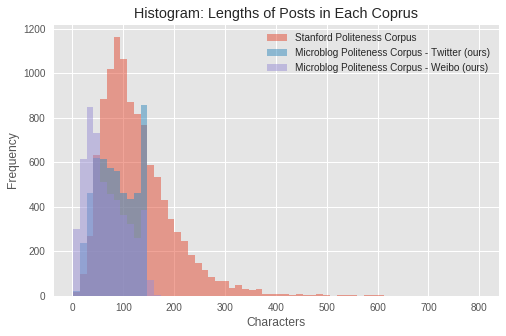

In [50]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
len_df = pd.DataFrame({"Stanford Politeness Corpus": text_feats_2scores_df['text'].apply(len).reset_index(drop=True),
"Microblog Politeness Corpus - Twitter (ours)": twitr_df['text'].apply(len).reset_index(drop=True),
"Microblog Politeness Corpus - Weibo (ours)": weibo_df['text'].apply(len).reset_index(drop=True),})
len_df.plot.hist(ax=ax, bins=60, alpha=.5)
plt.title("Histogram: Lengths of Posts in Each Coprus")
plt.xlabel("Characters")

In [54]:
len_df.median()#.describe().T

Stanford Politeness Corpus                      112.0
Microblog Politeness Corpus - Twitter (ours)     83.0
Microblog Politeness Corpus - Weibo (ours)       58.0
dtype: float64

If we are conducting experiments following the Stanford paper, we need to subsample to the two extreme quartiles here. Else, we can keep all posts in each corpus.

In [6]:
if IF_SUBSAMPLE_TO_QUARTILES:
    # ------------------------------------- Twitter -----------------------------------------
    twitr_size = len(twitr_df)//4
    twitr_r_sids = twitr_df.head(twitr_size).index
    twitr_p_sids = twitr_df.tail(twitr_size).index
    print(f'There are {twitr_size} rude posts and {twitr_size} polite posts in Twitter.')
    
    # Register to main dataframe:
    twitr_df.loc[:, 'label'] = None
    twitr_df.loc[twitr_r_sids, 'label'] = -1
    twitr_df.loc[twitr_p_sids, 'label'] = 1
    
    # -------------------------------------- Weibo ------------------------------------------
    weibo_size = len(weibo_df)//4
    weibo_r_sids = weibo_df.head(weibo_size).index
    weibo_p_sids = weibo_df.tail(weibo_size).index
    print(f'There are {weibo_size} rude posts and {weibo_size} polite posts in Weibo.')
    
    # Register to main dataframe:
    weibo_df.loc[:, 'label'] = None
    weibo_df.loc[weibo_r_sids, 'label'] = -1
    weibo_df.loc[weibo_p_sids, 'label'] = 1
    
else:
    # Labels are simply the signs of the standardized average politeness scores.
    twitr_df.loc[:, 'label'] = (twitr_df['stdzd_avg']>=0).map({False: -1, True: 1})
    weibo_df.loc[:, 'label'] = (weibo_df['stdzd_avg']>=0).map({False: -1, True: 1})

twitr_y = twitr_df['label'].dropna().astype(int)
weibo_y = weibo_df['label'].dropna().astype(int)

pd.DataFrame({
    'Weibo': weibo_y.value_counts(),
    'Twitter': twitr_y.value_counts(),
})

There are 1325 rude posts and 1325 polite posts in Twitter.
There are 1325 rude posts and 1325 polite posts in Weibo.


,Weibo,Twitter
1,1325,1325
-1,1325,1325


Import lexica counts: 

In [7]:
# with pd.HDFStore(HDF_FPATH) as hdf: print('\n'.join(hdf.keys()))
twitr_liwc_vecs_df = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_liwc_cnts_df').reindex(twitr_y.index)
weibo_liwc_vecs_df = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_liwc_cnts_df').reindex(weibo_y.index)
common_liwc_ctgys  = list(set(twitr_liwc_vecs_df.columns).intersection(weibo_liwc_vecs_df))
twitr_liwc_vecs_df = twitr_liwc_vecs_df[common_liwc_ctgys]
weibo_liwc_vecs_df = weibo_liwc_vecs_df[common_liwc_ctgys]

# `nrc` is a historical name for EmoLex.
twitr_emolex_vecs_df  = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_nrc_cnts_df').reindex(twitr_y.index)
weibo_emolex_vecs_df  = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_nrc_cnts_df').reindex(weibo_y.index)
twitr_emolex_vecs_df.columns = '*'+twitr_emolex_vecs_df.columns
weibo_emolex_vecs_df.columns = '*'+weibo_emolex_vecs_df.columns

twitr_polite_vecs_df = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_polite_cnts_df').reindex(twitr_y.index)
weibo_polite_vecs_df = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_polite_cnts_df').reindex(weibo_y.index)
twitr_polite_vecs_df.columns = '+'+twitr_polite_vecs_df.columns
weibo_polite_vecs_df.columns = '+'+weibo_polite_vecs_df.columns

# Stanford Feature Set is only available for English, thus it's only available for Twitter US Corpus.
twitr_stfd_vecs_df = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_stfd_df').reindex(twitr_y.index)
twitr_stfd_vecs_df.columns = '!'+twitr_stfd_vecs_df.columns


# Normalizations:

if IF_NORMALIZE_BY_TOKEN_COUNTS:
    twitr_token_cnts = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_token').apply(len).reindex(twitr_y.index)
    weibo_token_cnts = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_token').apply(len).reindex(weibo_y.index)
    
    twitr_liwc_vecs_df = (twitr_liwc_vecs_df.T/twitr_token_cnts).T
    weibo_liwc_vecs_df = (weibo_liwc_vecs_df.T/weibo_token_cnts).T
    
    twitr_emolex_vecs_df = (twitr_emolex_vecs_df.T/twitr_token_cnts).T
    weibo_emolex_vecs_df = (weibo_emolex_vecs_df.T/weibo_token_cnts).T
    
    twitr_polite_vecs_df = (twitr_polite_vecs_df.T/twitr_token_cnts).T
    weibo_polite_vecs_df = (weibo_polite_vecs_df.T/weibo_token_cnts).T
    #twitr_stfd_vecs_df = (twitr_stfd_vecs_df.T/twitr_token_cnts).T
    
if IF_BINARIFY:
    twitr_liwc_vecs_df   = twitr_liwc_vecs_df  >0
    twitr_emolex_vecs_df    = twitr_emolex_vecs_df   >0
    twitr_polite_vecs_df = twitr_polite_vecs_df>0
    weibo_liwc_vecs_df   = weibo_liwc_vecs_df  >0
    weibo_emolex_vecs_df    = weibo_emolex_vecs_df   >0
    weibo_polite_vecs_df = weibo_polite_vecs_df>0
    # twitr_stfd_vecs_df   = twitr_stfd_vecs_df  >0 # Already binary
    
# Handy functions that we willn eed to use later in analysis and presentation stages.
renameFeatCombos = lambda x: x.replace('l', 'LIWC +\n').replace('e', 'EmoLex +\n').replace('p', 'PoliteLex +\n').replace('s', 'Stanford Features +\n').rstrip(' +\n')
renameCorpus = lambda x: {'twitr': 'Twitter', 'weibo': 'Weibo'}[x]

In [8]:
corpus_to_feats_and_labels = {
    'weibo': {
        'feats': {
            'l': weibo_liwc_vecs_df,
            'e': weibo_emolex_vecs_df,
            'p': weibo_polite_vecs_df,
        },
        'labels': weibo_y,
    },
    'twitr': {
        'feats': {
            'l': twitr_liwc_vecs_df,
            'e': twitr_emolex_vecs_df,
            'p': twitr_polite_vecs_df,
            's': twitr_stfd_vecs_df,
        },
        'labels': twitr_y,
    },
}

## Feature-wise Ablation Study

In [ ]:
def ablationStudy(corpus_name):
    feats_and_labels = corpus_to_feats_and_labels[corpus_name]
    all_featureSets = feats_and_labels['feats'].values()
    allFeats_df = pd.concat(all_featureSets, sort=False, axis=1)
    results = {}
    with tqdm(allFeats_df.columns, desc="Ablation on "+corpus_name) as pbar:
        for feature in pbar:
            X = allFeats_df.drop(feature, axis=1)
            y = feats_and_labels['labels'].reindex(X.index)
            cv = GridSearchCV(SVC(probability=True), params, verbose=False, n_jobs=20, cv=5)
            cv.fit(X, y)
            results[feature] = cv
    return results

cvs = {
    'twitr': ablationStudy("twitr"),
    'weibo': ablationStudy("weibo"),
}

from joblib import dump, load
dump(cvs, f'ablationStudy_cvs{"" if IF_SUBSAMPLE_TO_QUARTILES else "_noQuartileFiltering"}.joblib')

Ablation on twitr:  66%|██████▋   | 83/125 [56:03<28:24, 40.58s/it]  

In [16]:
def readResultsForTheBestEstimatorFromEachCv(cvs: dict)-> pd.Series:
    for corpus_name, corpus_cvs in cvs.items():
        for feature, cv in corpus_cvs.items():
            bestEstimator_cvResults = pd.DataFrame(cv.cv_results_).iloc[cv.best_index_]
            bestEstimator_cvResults['feature'] = feature
            bestEstimator_cvResults['corpus'] = corpus_name
            yield bestEstimator_cvResults

# Results for the best estimator from each CV object:
cvs_df = pd.DataFrame(list(readResultsForTheBestEstimatorFromEachCv(cvs)))
cvs_df.set_index(['corpus', 'feature'], inplace=True)
cvs_df.to_csv(f'weibo+twitr_{NUM_POSTS}Each{"" if IF_SUBSAMPLE_TO_QUARTILES else "_ablationStudy_noQuartileFiltering"}_cvResults_df.csv')
cvs_df.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
corpus feature                                                                 
twitr  Anx           3.474722      0.460420         0.119050        0.017016   
       Shehe         3.740550      0.517964         0.108842        0.020882   

                param_C  param_gamma param_kernel  \
corpus feature                                      
twitr  Anx         0.05        0.001       linear   
       Shehe       0.10        0.001       linear   

                                                         params  \
corpus feature                                                    
twitr  Anx      {'C': 0.05, 'gamma': 0.001, 'kernel': 'linear'}   
       Shehe     {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}   

                split0_test_score  split1_test_score  split2_test_score  \
corpus feature                                                            
twitr  Anx               0.703774           0.696226           0.707547   
       Shehe             0.692453           0.698113           0.705660   

                split3_test_score  split4_test_score  mean_test_score  \
corpus feature                                                          
twitr  Anx               0.769811           0.771698         0.729811   
       Shehe             0.764151           0.773585         0.726792   

                std_test_score  rank_test_score  
corpus feature                                   
twitr  Anx            0.033634                1  
       Shehe          0.034737                1

In [72]:
abl_df = cvs_df['mean_test_score'].unstack(0).dropna()

In [73]:
def splitPrefixIntoAnotherColumn(t):
    if t[0]=='*':
        return 'EmoLex', t[1:]
    if t[0]=='+':
        return 'PoliteLex', t[1:]
    return 'LIWC', t
new_index = abl_df.index.to_series().apply(splitPrefixIntoAnotherColumn).apply(pd.Series).rename(columns={0: 'lex', 1: 'feature'})
abl_df = pd.concat([abl_df, new_index],axis=1).set_index(['lex', 'feature'])
abl_df.head()

twitr     weibo
lex    feature                         
EmoLex Anger         0.725660  0.781132
       Anticipation  0.729434  0.780000
       Disgust       0.727547  0.779245
       Fear          0.730943  0.779623
       Joy           0.720755  0.778868

In [74]:
abl_avgs = abl_df.T.mean().sort_values(ascending=True)
abl_df = abl_df.reindex(abl_avgs.index)
abl_df.head()

twitr     weibo
lex       feature                       
PoliteLex gratitude   0.727170  0.723396
          apologetic  0.726038  0.769811
EmoLex    Joy         0.720755  0.778868
LIWC      Swear       0.725660  0.777358
EmoLex    Trust       0.724528  0.778868

In [67]:
abl_df.to_csv(f'weibo+twitr_{NUM_POSTS}Each{"" if IF_SUBSAMPLE_TO_QUARTILES else "_ablationStudy_noQuartileFiltering"}_accuranciesWithEachFeatureRemoved_df.csv')

In [68]:
corr_df = pd.read_csv('concat_significantOnly_wide_df_5300_WeiboABCDTwitrABDE.csv', index_col=['lex','feature'])
corr_avgs = corr_df.T.mean().sort_values(ascending=True)
corr_df = corr_df.reindex(corr_avgs.index)
corr_df.head()

Twitter     Weibo
lex       feature                      
PoliteLex you_direct      NaN -0.387303
LIWC      Swear      -0.42129 -0.329483
PoliteLex taboo      -0.41714 -0.324693
LIWC      You             NaN -0.356683
          Anger      -0.36707 -0.254245

In [90]:
avgs_df = pd.DataFrame({
    'corr': corr_avgs.abs(), # because the higher the absolute value, the higher predictive power.
    'abl': -abl_avgs, # Because the lower the value, the higher predictive power.
})

In [92]:
avgs_df.corr(method='spearman')

,corr,abl
corr,1.000000,0.115117
abl,0.115117,1.000000


In [96]:
pd.concat([
    corr_df, 
    abl_df,
], sort=False, axis=1).to_csv('abl_and_corr.csv')

## Train 5-fold Cross Validations

In [9]:
from itertools import combinations
def allCombinations(iterable):
    '''l, e, p -> l, e, p, le, ep, lp, lep'''
    for num_featureSets_toUse in range(1, len(iterable)+1):
        for i in combinations(iterable, num_featureSets_toUse):
            # Skip combinations of the Stanford Feature Set with any other feature sets.
            if 's' in i and len(i)>1: continue
            yield i

def getFeatureSet(initial2vecsDf: dict, initials) -> pd.DataFrame:
    selected_featureSets = [initial2vecsDf[i] for i in initials]
    featureSet_df = pd.concat(selected_featureSets, sort=False, axis=1)
    return featureSet_df

def trainCv(acronym, initial2vecsDf, labels, pbar):
    # Housekeeping tasks.
    cv = GridSearchCV(SVC(probability=True), params, verbose=True, n_jobs=20)

    # Prepare data and actually train the CV object.
    X = getFeatureSet(initial2vecsDf, acronym)
    y = labels.reindex(X.index)
    pbar.write(f"## {acronym}\t(# samples, # feats) = {X.shape}")
    cv.fit(X, y)

    return cv

def experiment(corpus: str) -> dict:
    '''Performs an experiment.'''
    initial2vecsDf = corpus_to_feats_and_labels[corpus]['feats']
    labels = corpus_to_feats_and_labels[corpus]['labels']
    
    # Figure out total number of combinations we need to try.
    n = len(list(allCombinations(initial2vecsDf)))
    
    # This nested dict maps `this_combination_acronym` to CV objects.
    cvs = dict()

    all_combos = allCombinations(initial2vecsDf)
    with tqdm(all_combos, total=n, desc=f"Experiments on the {corpus} Corpus") as pbar:
        for initials in pbar:
            acronym = ''.join(initials)
            cvs[acronym] = trainCv(acronym, initial2vecsDf, labels, pbar)
    return cvs

In [10]:
cvs = {
    'twitr': experiment("twitr"),
    'weibo': experiment("weibo"),
}

from joblib import dump, load
dump(cvs, f'cvs{"" if IF_SUBSAMPLE_TO_QUARTILES else "_noQuartileFiltering"}.joblib')

Experiments on the twitr Corpus:   0%|          | 0/8 [00:00<?, ?it/s]

## l	(# samples, # feats) = (2650, 70)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:   12.7s finished
Experiments on the twitr Corpus:  12%|█▎        | 1/8 [00:15<01:47, 15.38s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## e	(# samples, # feats) = (2650, 8)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:    3.1s finished
Experiments on the twitr Corpus:  25%|██▌       | 2/8 [00:19<01:11, 11.98s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## p	(# samples, # feats) = (2650, 26)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:    4.2s finished
Experiments on the twitr Corpus:  38%|███▊      | 3/8 [00:24<00:49, 10.00s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## s	(# samples, # feats) = (2650, 21)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:    3.9s finished
Experiments on the twitr Corpus:  50%|█████     | 4/8 [00:29<00:34,  8.50s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## le	(# samples, # feats) = (2650, 78)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:   12.4s finished
Experiments on the twitr Corpus:  62%|██████▎   | 5/8 [00:47<00:33, 11.20s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## lp	(# samples, # feats) = (2650, 96)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:   15.2s finished
Experiments on the twitr Corpus:  75%|███████▌  | 6/8 [01:07<00:28, 14.02s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## ep	(# samples, # feats) = (2650, 34)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:    6.0s finished
Experiments on the twitr Corpus:  88%|████████▊ | 7/8 [01:15<00:12, 12.08s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## lep	(# samples, # feats) = (2650, 104)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:   15.7s finished
Experiments on the weibo Corpus:   0%|          | 0/7 [00:00<?, ?it/s]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## l	(# samples, # feats) = (2650, 70)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:   20.6s finished
Experiments on the weibo Corpus:  14%|█▍        | 1/7 [00:23<02:20, 23.45s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## e	(# samples, # feats) = (2650, 8)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:    3.6s finished
Experiments on the weibo Corpus:  29%|██▊       | 2/7 [00:28<01:28, 17.79s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## p	(# samples, # feats) = (2650, 26)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:    4.1s finished
Experiments on the weibo Corpus:  43%|████▎     | 3/7 [00:33<00:56, 14.08s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## le	(# samples, # feats) = (2650, 78)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:   22.5s finished
Experiments on the weibo Corpus:  57%|█████▋    | 4/7 [00:59<00:52, 17.53s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## lp	(# samples, # feats) = (2650, 96)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:   25.6s finished
Experiments on the weibo Corpus:  71%|███████▏  | 5/7 [01:38<00:47, 23.96s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## ep	(# samples, # feats) = (2650, 34)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:    6.0s finished
Experiments on the weibo Corpus:  86%|████████▌ | 6/7 [01:45<00:19, 19.14s/it]/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


## lep	(# samples, # feats) = (2650, 104)
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 105 out of 105 | elapsed:   28.5s finished
Experiments on the weibo Corpus: 100%|██████████| 7/7 [02:28<00:00, 21.14s/it]


['cvs.joblib']

## Performance Analysis

### Plot Violin plot

In [11]:
def readResultsForTheBestEstimatorFromEachCv(cvs: dict)-> pd.Series:
    for corpus_name, corpus_cvs in cvs.items():
        for this_combination_acronym, cv in corpus_cvs.items():
            bestEstimator_cvResults = pd.DataFrame(cv.cv_results_).iloc[cv.best_index_]
            bestEstimator_cvResults['feat_combo'] = this_combination_acronym
            bestEstimator_cvResults['corpus'] = corpus_name
            yield bestEstimator_cvResults

# Results for the best estimator from each CV object:
cvs_df = pd.DataFrame(list(readResultsForTheBestEstimatorFromEachCv(cvs)))
cvs_df.set_index(['corpus', 'feat_combo'], inplace=True)
cvs_df.to_csv(f'weibo+twitr_{NUM_POSTS}Each{"" if IF_SUBSAMPLE_TO_QUARTILES else "_noQuartileFiltering"}_cvResults_df.csv')
cvs_df.head(2)

mean_fit_time  std_fit_time  mean_score_time  \
corpus feat_combo                                                 
twitr  l                1.298639      0.164584         0.083283   
       e                0.503121      0.096690         0.030042   

                   std_score_time  param_C  param_gamma param_kernel  \
corpus feat_combo                                                      
twitr  l                 0.004506     0.05        0.001       linear   
       e                 0.006967     0.25        0.001       linear   

                                                            params  \
corpus feat_combo                                                    
twitr  l           {'C': 0.05, 'gamma': 0.001, 'kernel': 'linear'}   
       e           {'C': 0.25, 'gamma': 0.001, 'kernel': 'linear'}   

                   split0_test_score  split1_test_score  split2_test_score  \
corpus feat_combo                                                            
twitr  l                    0.660633           0.719457           0.770975   
       e                    0.557692           0.581448           0.614512   

                   mean_test_score  std_test_score  rank_test_score  
corpus feat_combo                                                    
twitr  l                  0.716981        0.045072                1  
       e                  0.584528        0.023295                1

In [12]:
cvs_testScores_df = cvs_df[['mean_test_score', 'std_test_score']]\
    .reset_index()\
    .sort_values(['corpus', 'mean_test_score'])\
    .set_index(['corpus', 'feat_combo'])
cvs_testScores_df.to_csv(f'weibo+twitr_{NUM_POSTS}Each{"" if IF_SUBSAMPLE_TO_QUARTILES else "_noQuartileFiltering"}_std_testScores_df.csv')

In [13]:
# Filter for test scores of all splits from each CV.
cvs_testScores_raw_df = cvs_df[list(filter(lambda s: s.startswith('split') and s.endswith('test_score'), cvs_df.columns))]
cvs_testScores_raw_df.head(2)

split0_test_score  split1_test_score  split2_test_score
corpus feat_combo                                                         
twitr  l                    0.660633           0.719457           0.770975
       e                    0.557692           0.581448           0.614512

In [14]:
# Prepare a long form of the DF for plotting.
cvs_testScores_raw_long_df = cvs_testScores_raw_df.stack().reset_index(level=-1, drop=True).rename('value').reset_index()
cvs_testScores_raw_long_df.head(2)

,corpus,feat_combo,value
0,twitr,l,0.660633
1,twitr,l,0.719457


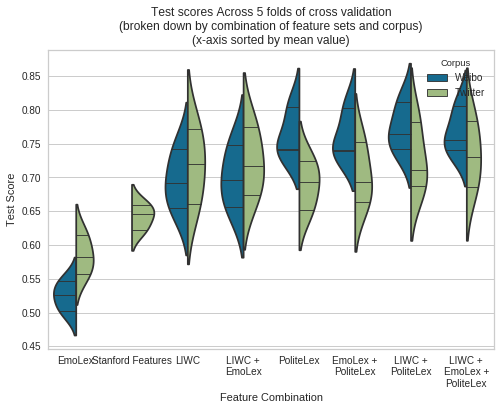

In [15]:
# Plot.

df = cvs_testScores_raw_long_df.rename(columns={
    'feat_combo': "Feature Combination",
    'value': 'Test Score',
    'corpus': 'Corpus',
})
df['Corpus'] = df['Corpus'].map({
    'weibo': 'Weibo',
    'twitr': 'Twitter',
})
df['Feature Combination'] = df['Feature Combination'].apply(renameFeatCombos)

testScores_avgedAcrossCorpora = cvs_testScores_df.reset_index().groupby('feat_combo')['mean_test_score'].mean()
order_of_featCombos = testScores_avgedAcrossCorpora.sort_values().index.to_series().apply(renameFeatCombos)

ax = sns.violinplot(
    data=df, 
    x='Feature Combination', 
    y='Test Score', 
    hue='Corpus', 
    split=True, 
    inner='stick', 
    hue_order=['Weibo', 'Twitter'],
    order=order_of_featCombos,
)

plt.xlabel("Feature Combination")
plt.ylabel("Test Score")
plt.title('Test scores Across 5 folds of cross validation\n(broken down by combination of feature sets and corpus)\n(x-axis sorted by mean value)')
plt.savefig(f'weibo+twitr_{NUM_POSTS}Each{"" if IF_SUBSAMPLE_TO_QUARTILES else "_noQuartileFiltering"}.png')
plt.show()

### Get Classification Report
`GridSearchCV` does not provide F1 Score nor ROCAUC. Here, we use all posts as test sample. In other words, we are not distinguishing test samples from training samples (is this a good idea?).

In [16]:
from joblib import load
cvs = load(f'cvs{"" if IF_SUBSAMPLE_TO_QUARTILES else "_noQuartileFiltering"}.joblib')

In [17]:
if 's' not in cvs['twitr']:
    twitr_stfd_cv = trainCv(
        initials=('s',),
        initial2vecsDf=corpus_to_feats_and_labels['twitr']['feats'], 
        labels=corpus_to_feats_and_labels['twitr']['labels'], 
        pbar=tqdm,
    )
    cvs['twitr']['s'] = twitr_stfd_cv

In [18]:
#accuracies = pd.DataFrame.from_dict(scores, orient='index').sort_values('accuracy', ascending=False).accuracy
from sklearn.metrics import roc_auc_score, accuracy_score

def getClassificationReport(y_hat, y_test, name=''):
    _ = classification_report(y_true=y_test, y_pred=y_hat, target_names=['rude', 'polite'], output_dict=True)
    _ = pd.DataFrame(_).drop('support').reset_index().rename(columns={'index': 'metric'}).assign(
        model=name).set_index(['model', 'metric'])['weighted avg'].unstack()
    return _.assign(ROCAUC   = roc_auc_score(y_true=y_test, y_score=y_hat, average='weighted'),
                    Accuracy = accuracy_score(y_true=y_test, y_pred=y_hat))

def getClassificationReportForAllCvs(cvs):
    for corpus, cvs_thisCorpus in cvs.items():
        initial2vecsDf = corpus_to_feats_and_labels[corpus]['feats']
        y = corpus_to_feats_and_labels[corpus]['labels']
        for acronym, cv_thisCombo in cvs_thisCorpus.items():
            # Take the best-performing estimator of this combination of corpus and feature set.
            estimator = cv_thisCombo.best_estimator_

            X = getFeatureSet(initial2vecsDf, acronym)
            y_hat = estimator.predict(X)

            result = getClassificationReport(y, y_hat).assign(
                corpus=corpus,
                acronym=acronym,
            )
            yield result

df = pd.concat(list(getClassificationReportForAllCvs(cvs)))
df['corpus'] = df['corpus'].apply(renameCorpus)
df['acronym'] = df['acronym'].apply(renameFeatCombos)
df['acronym'] = df['acronym'].str.replace('\n', ' ')
df.rename(columns={'corpus': 'Corpus', 'acronym': 'Feature Combination'}, inplace=True)
df.set_index(['Corpus', 'Feature Combination'], inplace=True)

In [19]:
df.to_csv(f'weibo+twitr_{NUM_POSTS}Each{"" if IF_SUBSAMPLE_TO_QUARTILES else "_noQuartileFiltering"}_clf_report_df.csv')
df

metric                             f1-score  precision    recall    ROCAUC  \
Corpus  Feature Combination                                                  
Twitter LIWC                       0.754796   0.760717  0.753962  0.757440   
        EmoLex                     0.599518   0.659142  0.583019  0.597928   
        PoliteLex                  0.720576   0.748578  0.715849  0.730968   
        Stanford Features          0.660993   0.665824  0.660000  0.661886   
        LIWC + EmoLex              0.760194   0.767093  0.759245  0.763379   
        LIWC + PoliteLex           0.772179   0.778795  0.771321  0.775438   
        EmoLex + PoliteLex         0.721548   0.750896  0.716604  0.732553   
        LIWC + EmoLex + PoliteLex  0.767826   0.775614  0.766792  0.771584   
Weibo   LIWC                       0.728826   0.746189  0.726038  0.735530   
        EmoLex                     0.597479   0.777340  0.532075  0.562958   
        PoliteLex                  0.779082   0.804288  0.775849  0.792485   
        LIWC + EmoLex              0.743334   0.760454  0.740755  0.750629   
        LIWC + PoliteLex           0.803394   0.823620  0.801132  0.815314   
        EmoLex + PoliteLex         0.777894   0.805354  0.774340  0.792482   
        LIWC + EmoLex + PoliteLex  0.804277   0.822415  0.802264  0.814958   

metric                             Accuracy  
Corpus  Feature Combination                  
Twitter LIWC                       0.753962  
        EmoLex                     0.583019  
        PoliteLex                  0.715849  
        Stanford Features          0.660000  
        LIWC + EmoLex              0.759245  
        LIWC + PoliteLex           0.771321  
        EmoLex + PoliteLex         0.716604  
        LIWC + EmoLex + PoliteLex  0.766792  
Weibo   LIWC                       0.726038  
        EmoLex                     0.532075  
        PoliteLex                  0.775849  
        LIWC + EmoLex              0.740755  
        LIWC + PoliteLex           0.801132  
        EmoLex + PoliteLex         0.774340  
        LIWC + EmoLex + PoliteLex  0.802264

In [20]:
# Compile to LaTeX:
l = df.round(3)

def highlightMaxValsForEachColForACorpus(sub_df):
    """prepends a `*`."""
    for metric, combo in sub_df.idxmax().iteritems():
        sub_df.loc[combo, metric] = f"*{sub_df.loc[combo, metric]}"
    return sub_df
l = l.reset_index('Corpus').groupby('Corpus').apply(highlightMaxValsForEachColForACorpus)
l.index = df.index

# Remove the default header (4 lines).
l = '\n'.join(l.to_latex().split('\n')[5:])

# Replace linebreak.
l = l.replace(r' \\', r'  \tabularnewline\cline{2-7}')

# Change top and bottom lines.
l = l.replace(r'\toprule', '').replace(r'\midrule', '')
l = l.replace(r'\bottomrule', '')#.replace('0.', '$0.').replace(' &', '$ &')

# Add my own header.
l = '''
\\begin{tabular}{|l|l|r|r|r|r|r|}
\hline
Corpus       &   Feature Set     &          F1 &    Precision &    Recall &    ROCAUC & Accuracy \\tabularnewline\hline\hline
'''+l

import re

# Surround numbers with `$`.
l = re.sub(r'(\*?0.\d{2,3})', r'$\1$', l)

# Convert asterisk to `\textbf{...}`.
l = re.sub(r'\*(0.\d{2,3})', r'\\textbf{\1}', l)

# Set up multirow.
l = l.replace('Twitter', '\multirow{6}{*}{Twitter}')
l = re.sub(r'\\cline{2-7}\nWeibo', r'\\hline\\hline\n\\multirow{6}{*}{Weibo}', l)
l = re.sub(r'\\cline{2-7}\s*\\end{tabular}$', r'\\hline\n\\end{tabular}', l)

print(l)



\begin{tabular}{|l|l|r|r|r|r|r|}
\hline
Corpus       &   Feature Set     &          F1 &    Precision &    Recall &    ROCAUC & Accuracy \tabularnewline\hline\hline
\multirow{6}{*}{Twitter} & LIWC &    $0.755$ &     $0.761$ &   $0.754$ &   $0.757$ &    $0.754$  \tabularnewline\cline{2-7}
      & EmoLex &      0.6 &     $0.659$ &   $0.583$ &   $0.598$ &    $0.583$  \tabularnewline\cline{2-7}
      & PoliteLex &    $0.721$ &     $0.749$ &   $0.716$ &   $0.731$ &    $0.716$  \tabularnewline\cline{2-7}
      & Stanford Features &    $0.661$ &     $0.666$ &    $0.66$ &   $0.662$ &     $0.66$  \tabularnewline\cline{2-7}
      & LIWC + EmoLex &     $0.76$ &     $0.767$ &   $0.759$ &   $0.763$ &    $0.759$  \tabularnewline\cline{2-7}
      & LIWC + PoliteLex &   $\textbf{0.772}$ &    $\textbf{0.779}$ &  $\textbf{0.771}$ &  $\textbf{0.775}$ &   $\textbf{0.771}$  \tabularnewline\cline{2-7}
      & EmoLex + PoliteLex &    $0.722$ &     $0.751$ &   $0.717$ &   $0.733$ &    $0.717$  \tabularnewlin